In [1]:
import numpy as np
import scipy.linalg
import scipy.io
import itertools
import matplotlib.pyplot as plt

from qiskit.visualization import *
from qiskit.extensions import UnitaryGate

# custom utility functions
from util import *
from qetu import *
from tfim import *
from fermi_hubbard import *
from wmi_backend import *

### Single Trotter step

In [2]:
nqubits = 2
nsysqubits = 2*nqubits
μ = 0
u = 3
t = 2
delta_t = 1

#### Construct controlled Trotter

In [3]:
def add_zcz_wmi(circuit, control, target):
    """
    Add a zero-controlled z-gate decomposed into the gate set of the WMI
    """
    circuit.x(control)
    circuit.x(target)
    circuit.rz(np.pi, target)
    circuit.cp(np.pi, control, target)
    circuit.x(control)
    circuit.x(target)

def add_zcx_wmi(circuit, control, target):
    """
    Add a zero-controlled x-gate decomposed into the gate set of the WMI
    """
    circuit.sx(control)
    circuit.rx(3/2*np.pi, control)
    circuit.sx(control)
    circuit.x(target)
    circuit.cp(np.pi, control, target)
    circuit.x(target)
    circuit.rz(-np.pi, target)
    circuit.sx(control)
    circuit.rx(3/2*np.pi, control)
    circuit.sx(control)

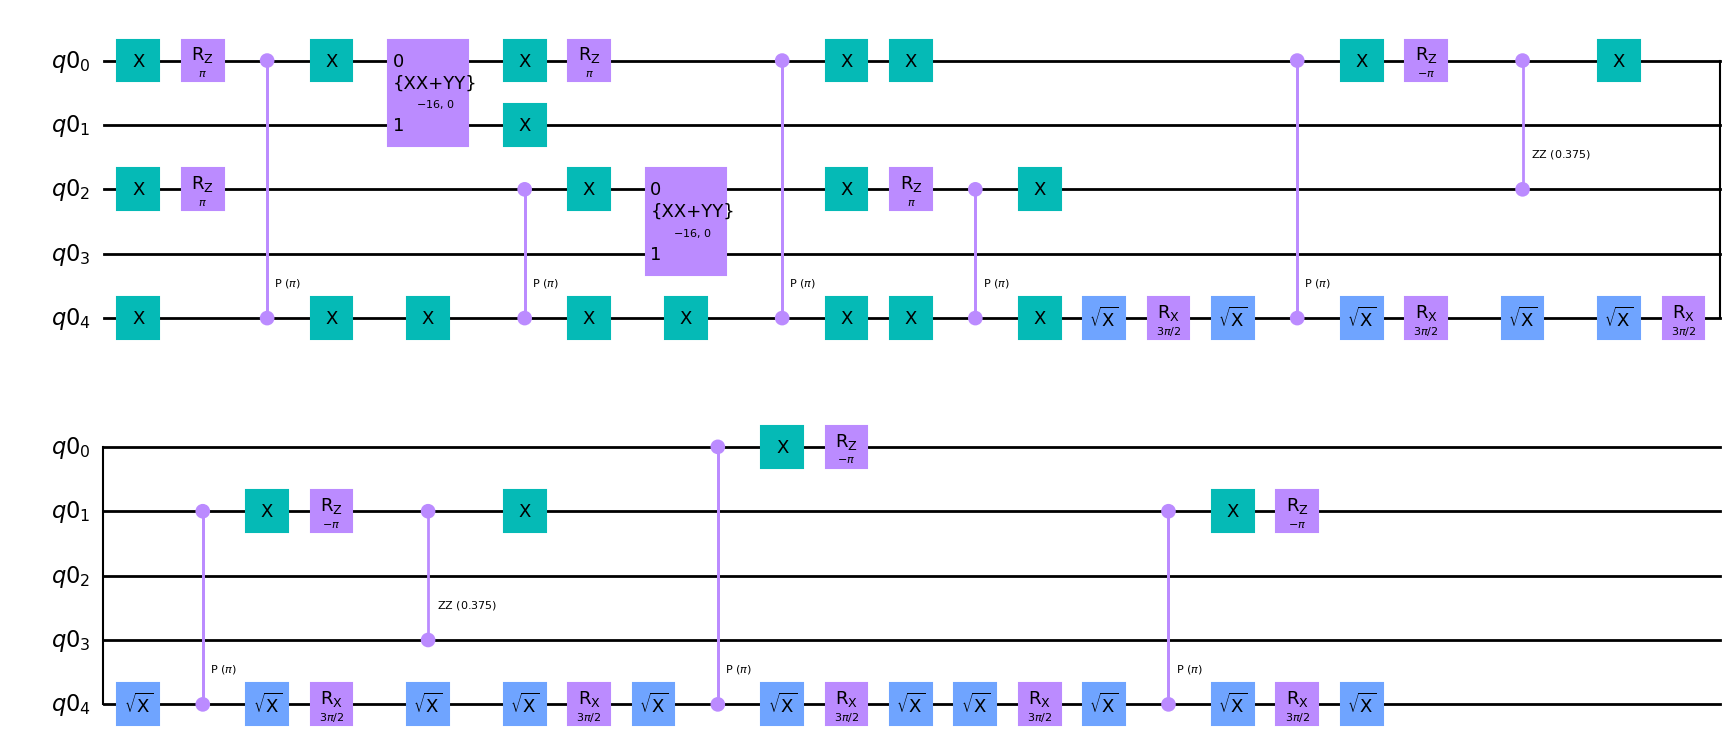

In [4]:
from qiskit.circuit.library import PhaseGate
from qiskit.quantum_info.operators import Operator

q = QuantumRegister(5)
qc_trotter = QuantumCircuit(q)

# calculate theta for XXPlusYY gate
theta = -8*t
beta = 0
#qc_trotter.barrier(q)
add_zcz_wmi(qc_trotter, 4, 0)
add_zcz_wmi(qc_trotter, 4, 2)
#qc_trotter.barrier(q)
qc_trotter.append(XXPlusYYGate(theta, beta), [0, 1])
qc_trotter.append(XXPlusYYGate(theta, beta), [2, 3])
#qc_trotter.barrier(q)
add_zcz_wmi(qc_trotter, 4, 0)
add_zcz_wmi(qc_trotter, 4, 2)
#qc_trotter.barrier(q)
#qc_trotter.barrier(q)
add_zcx_wmi(qc_trotter, 4, 0)
add_zcx_wmi(qc_trotter, 4, 1)
#qc_trotter.barrier(q)
θ = 1/4 * delta_t * u / nqubits
qc_trotter.rzz(θ, q[0], q[2])
qc_trotter.rzz(θ, q[1], q[3])
#qc_trotter.barrier(q)
add_zcx_wmi(qc_trotter, 4, 0)
add_zcx_wmi(qc_trotter, 4, 1)

qc_trotter.draw("mpl")

In [5]:
backend = FakeWMI()
noise_model = NoiseModel.from_backend(backend)
noise_model

<NoiseModel on ['cp', 'xx_plus_yy', 'sx', 'x', 'y', 'measure', 'iswap']>

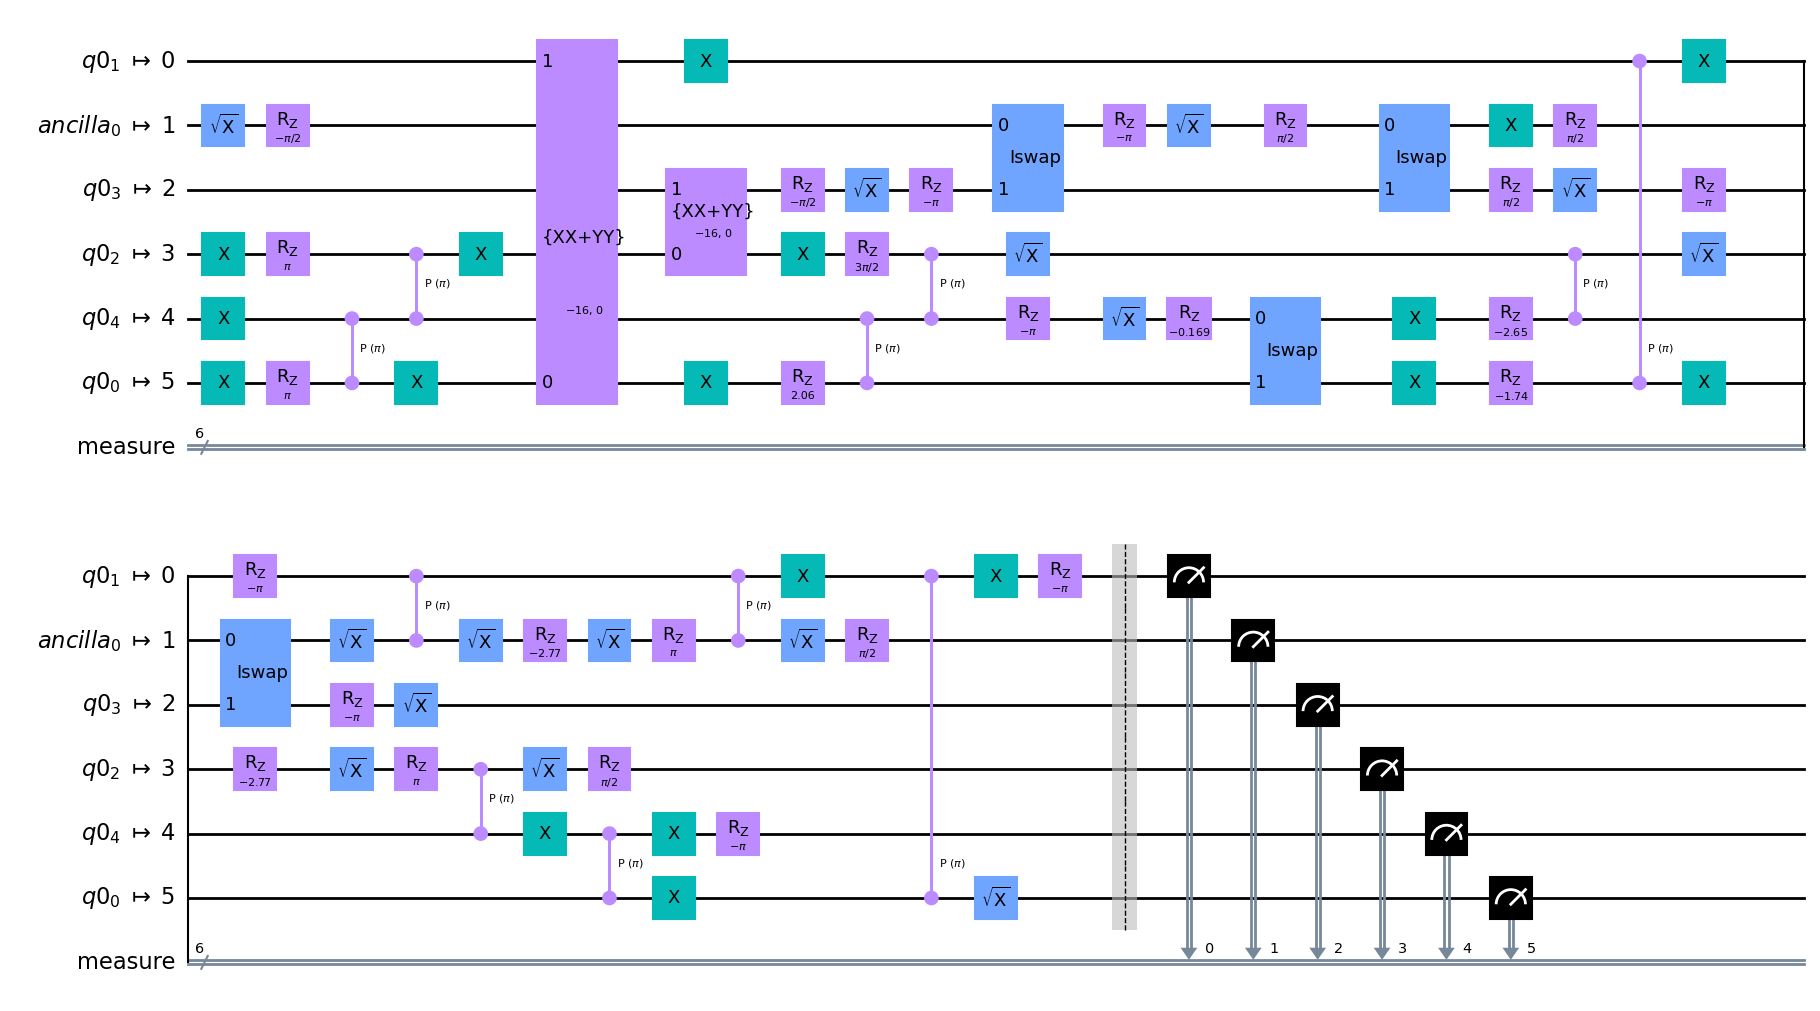

In [6]:
# Transpile to WMI hardware
test_circ = transpile(
    qc_trotter,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()
test_circ.draw("mpl")

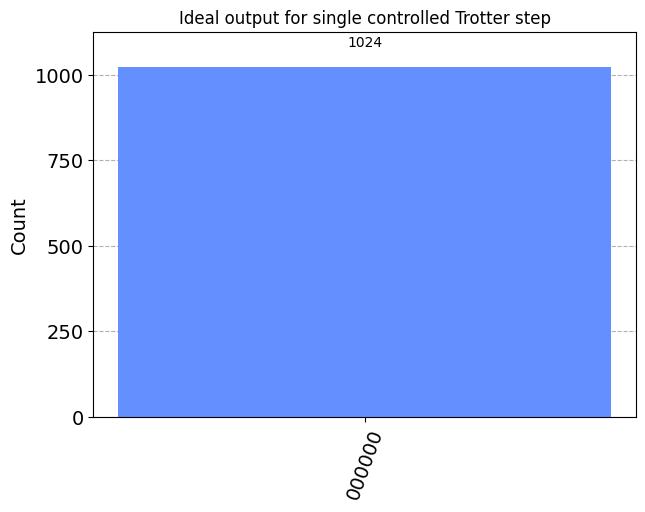

In [7]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for single controlled Trotter step')

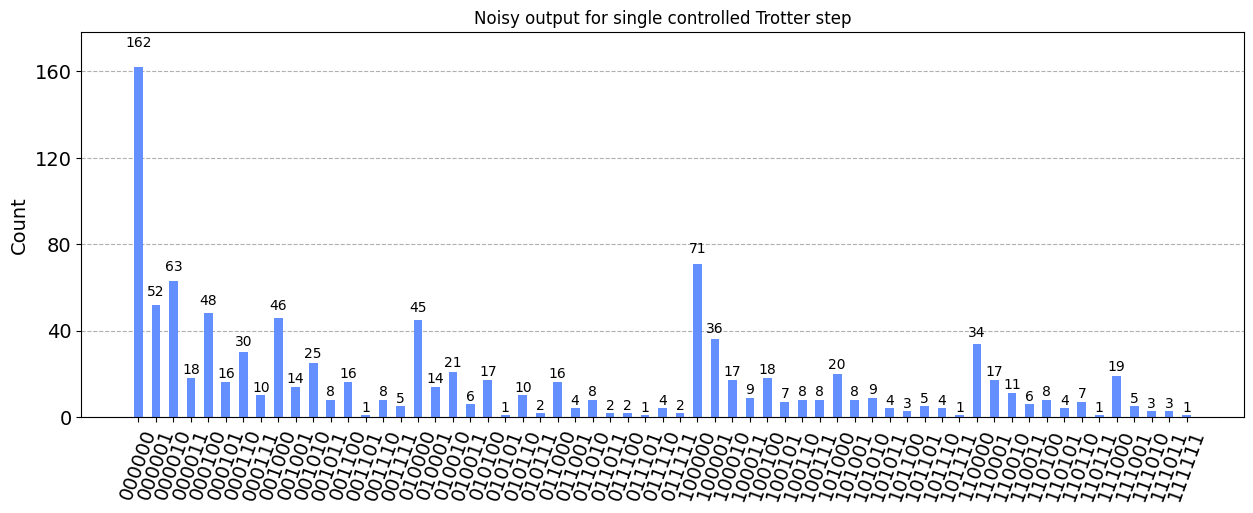

In [8]:
# Create noisy simulator and transpile circuit
wmi_backend = FakeWMI()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
test_circ = add_xx_plus_yy_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for single controlled Trotter step', figsize=(15,5))

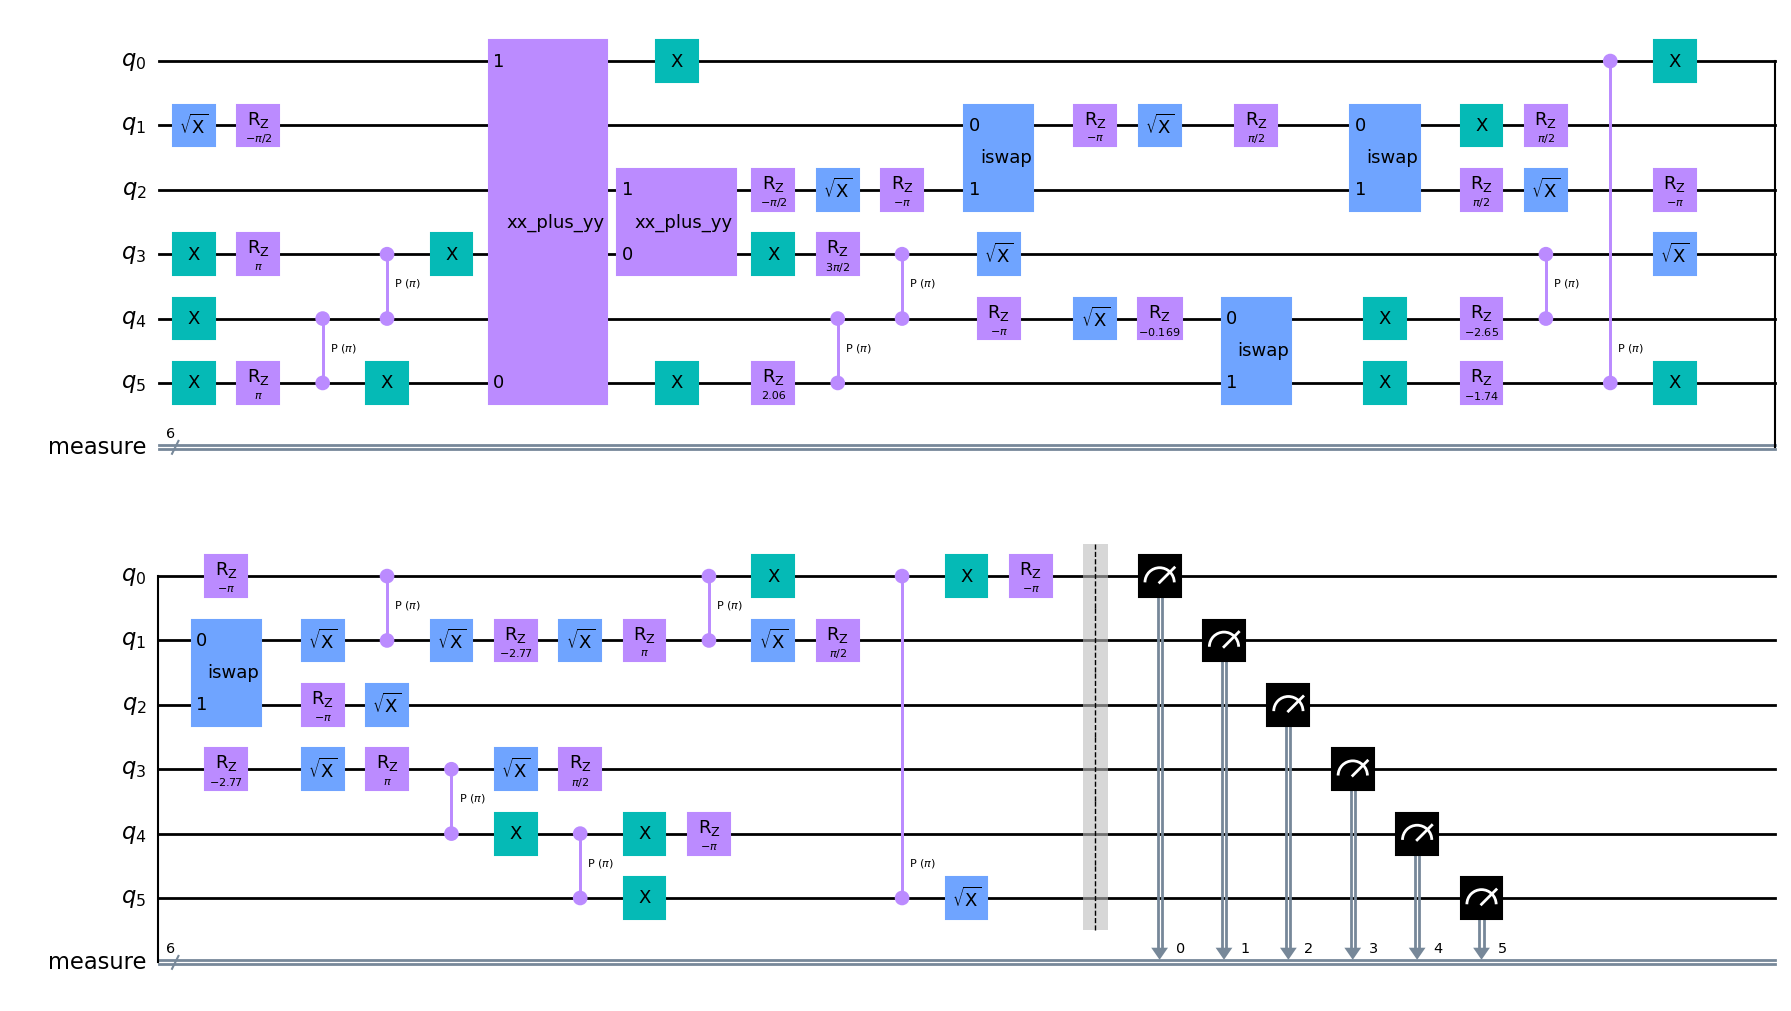

In [9]:
t_test_circ_noise.draw("mpl")

In [10]:
print(t_test_circ_noise.depth())

30


### QETU test

In [11]:
cheb_qsp_angles = [1.2121, -0.2663, 1.2121]
U_qc = QETU(qc_trotter, convert_Zrot_to_Xrot(cheb_qsp_angles))
U_qetu = get_matrix(U_qc)[0:16, 0:16]

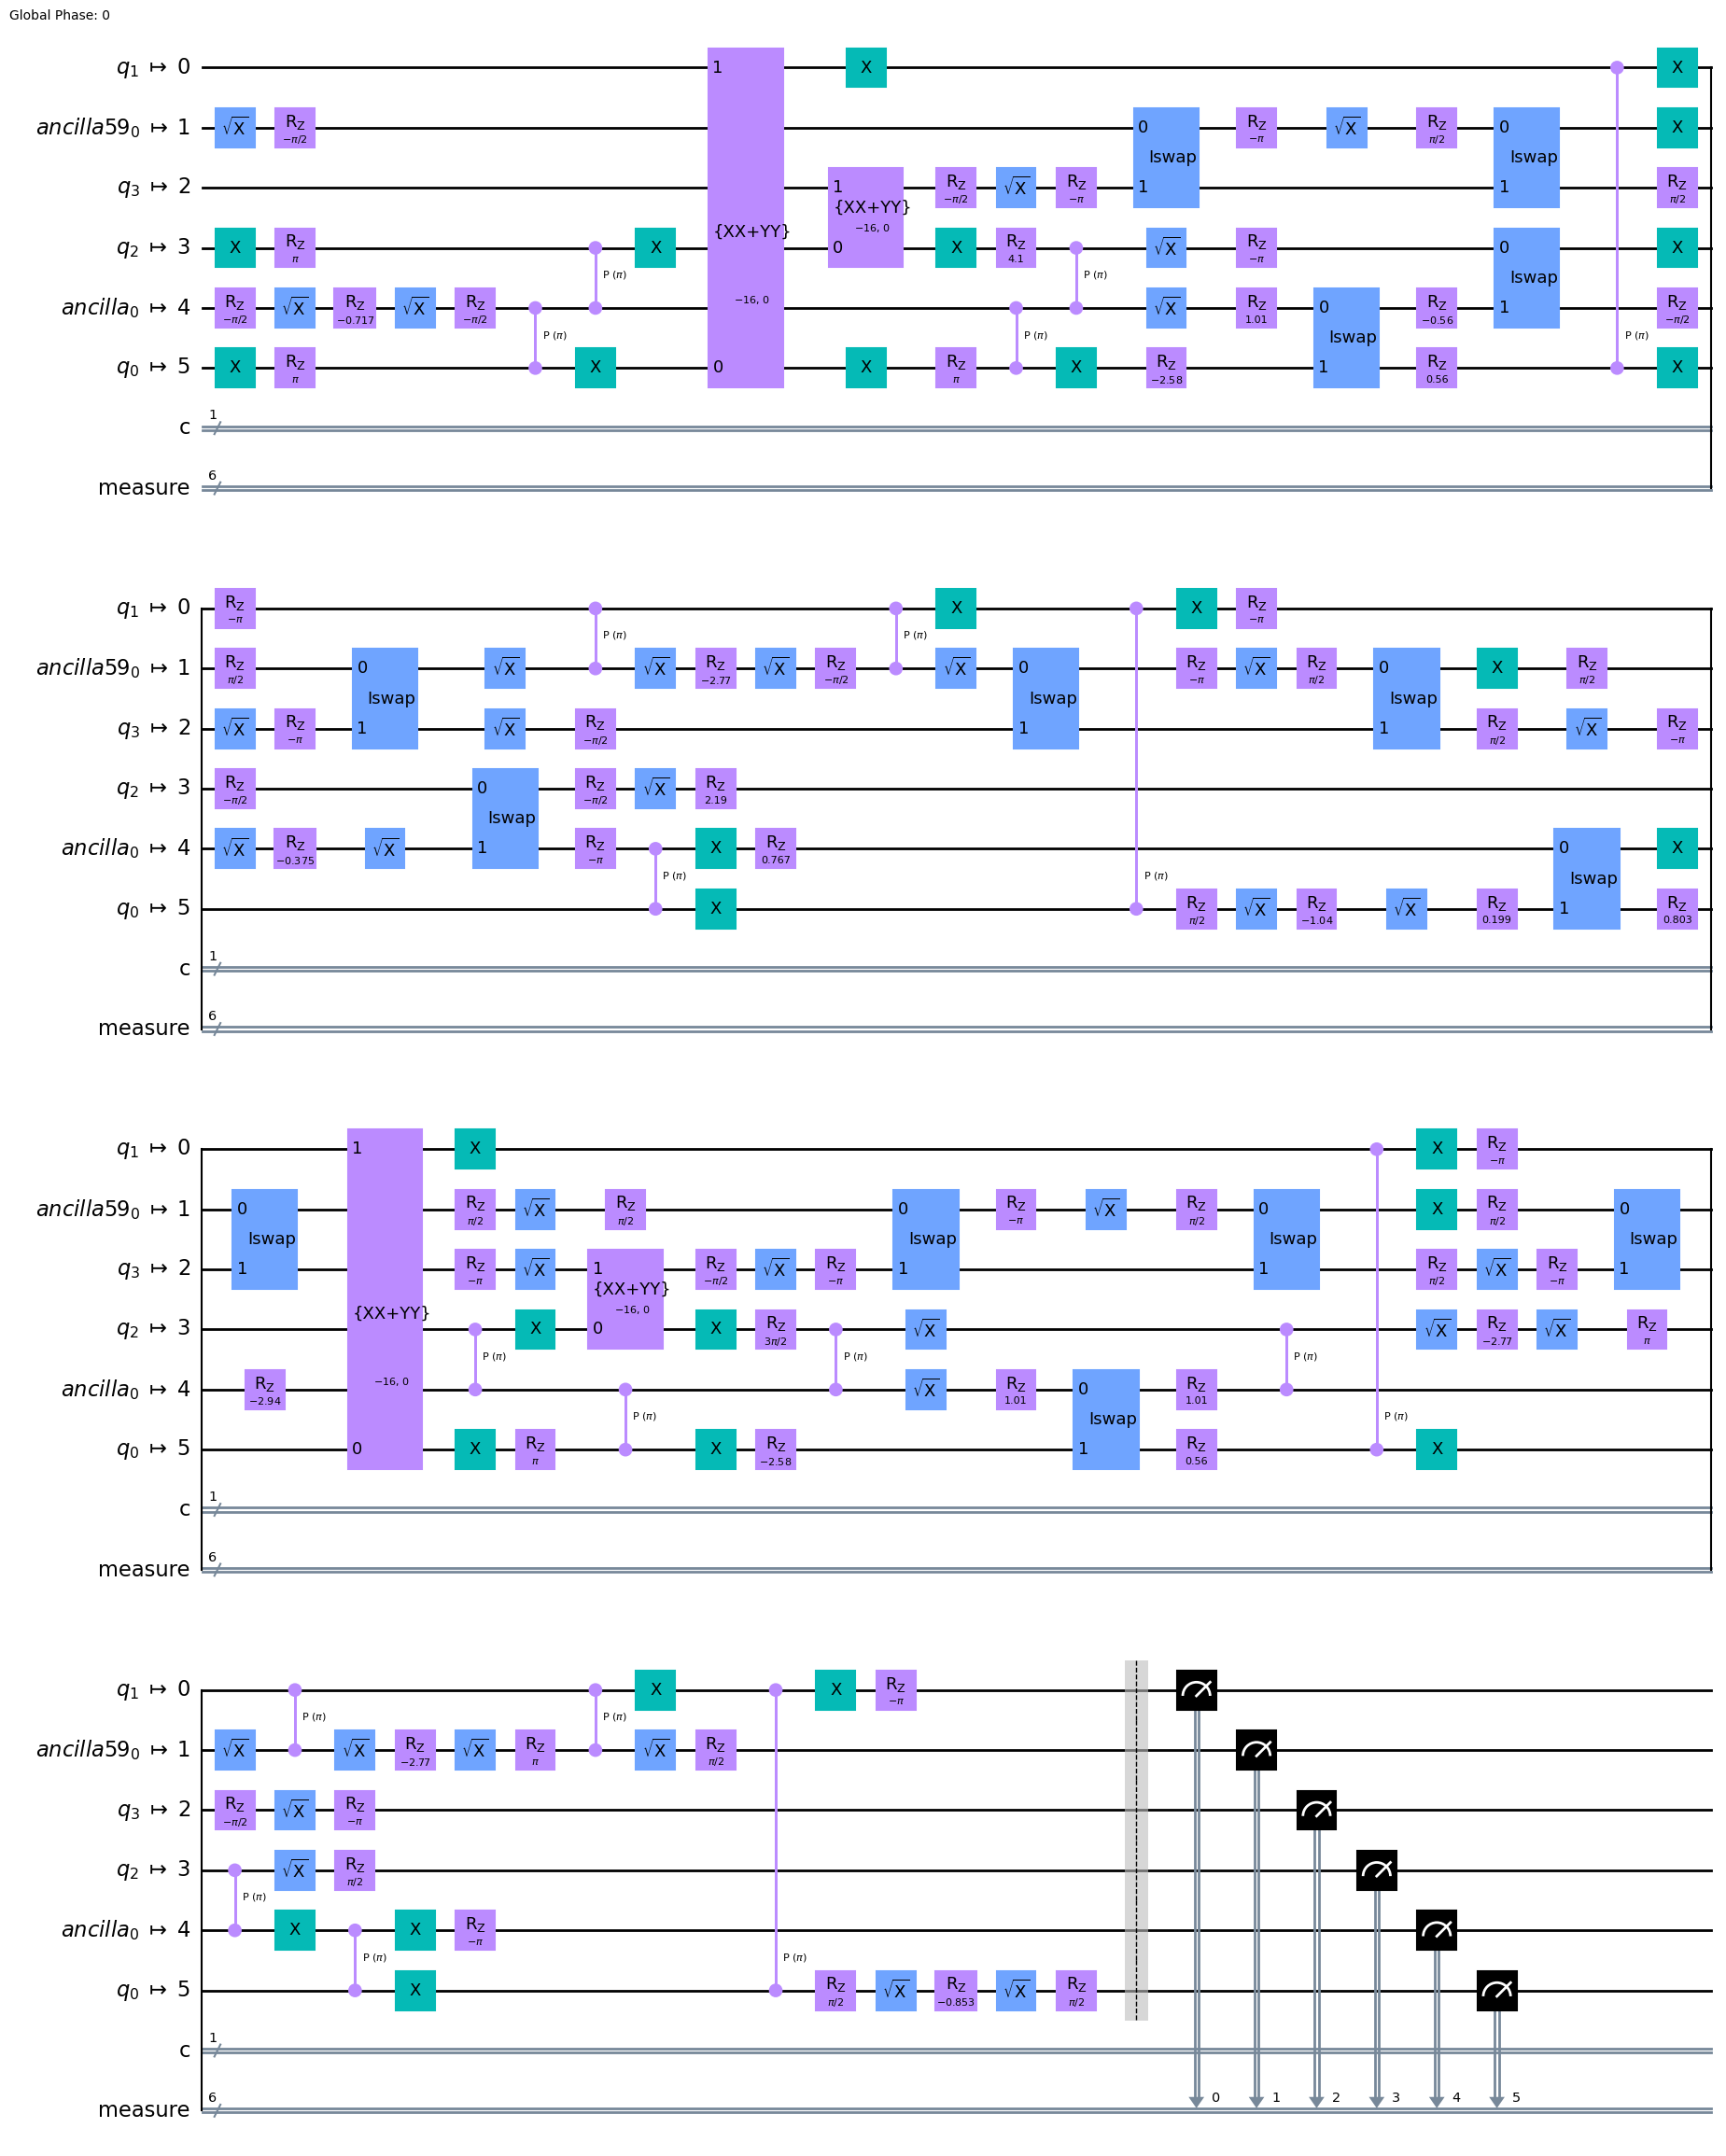

In [12]:
# Transpile to WMI hardware
test_circ = transpile(
    U_qc,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()
test_circ.draw("mpl")

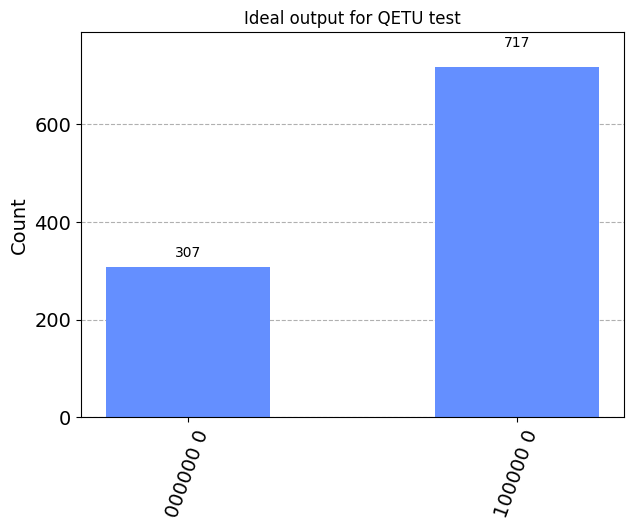

In [13]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for QETU test')

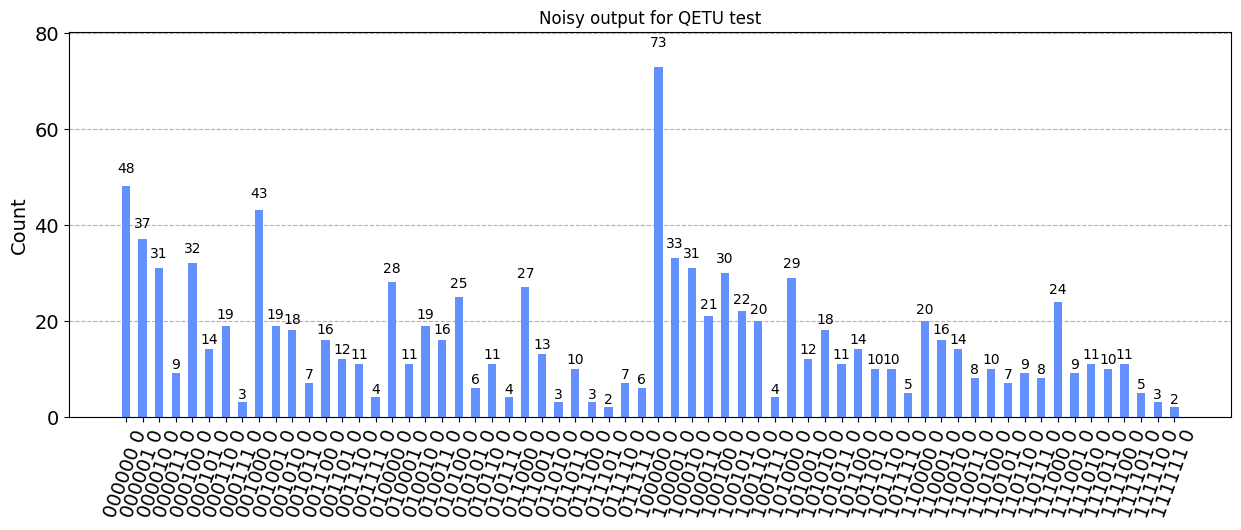

In [14]:
# Create noisy simulator and transpile circuit
wmi_backend = FakeWMI()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
test_circ = add_xx_plus_yy_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for QETU test', figsize=(15,5))

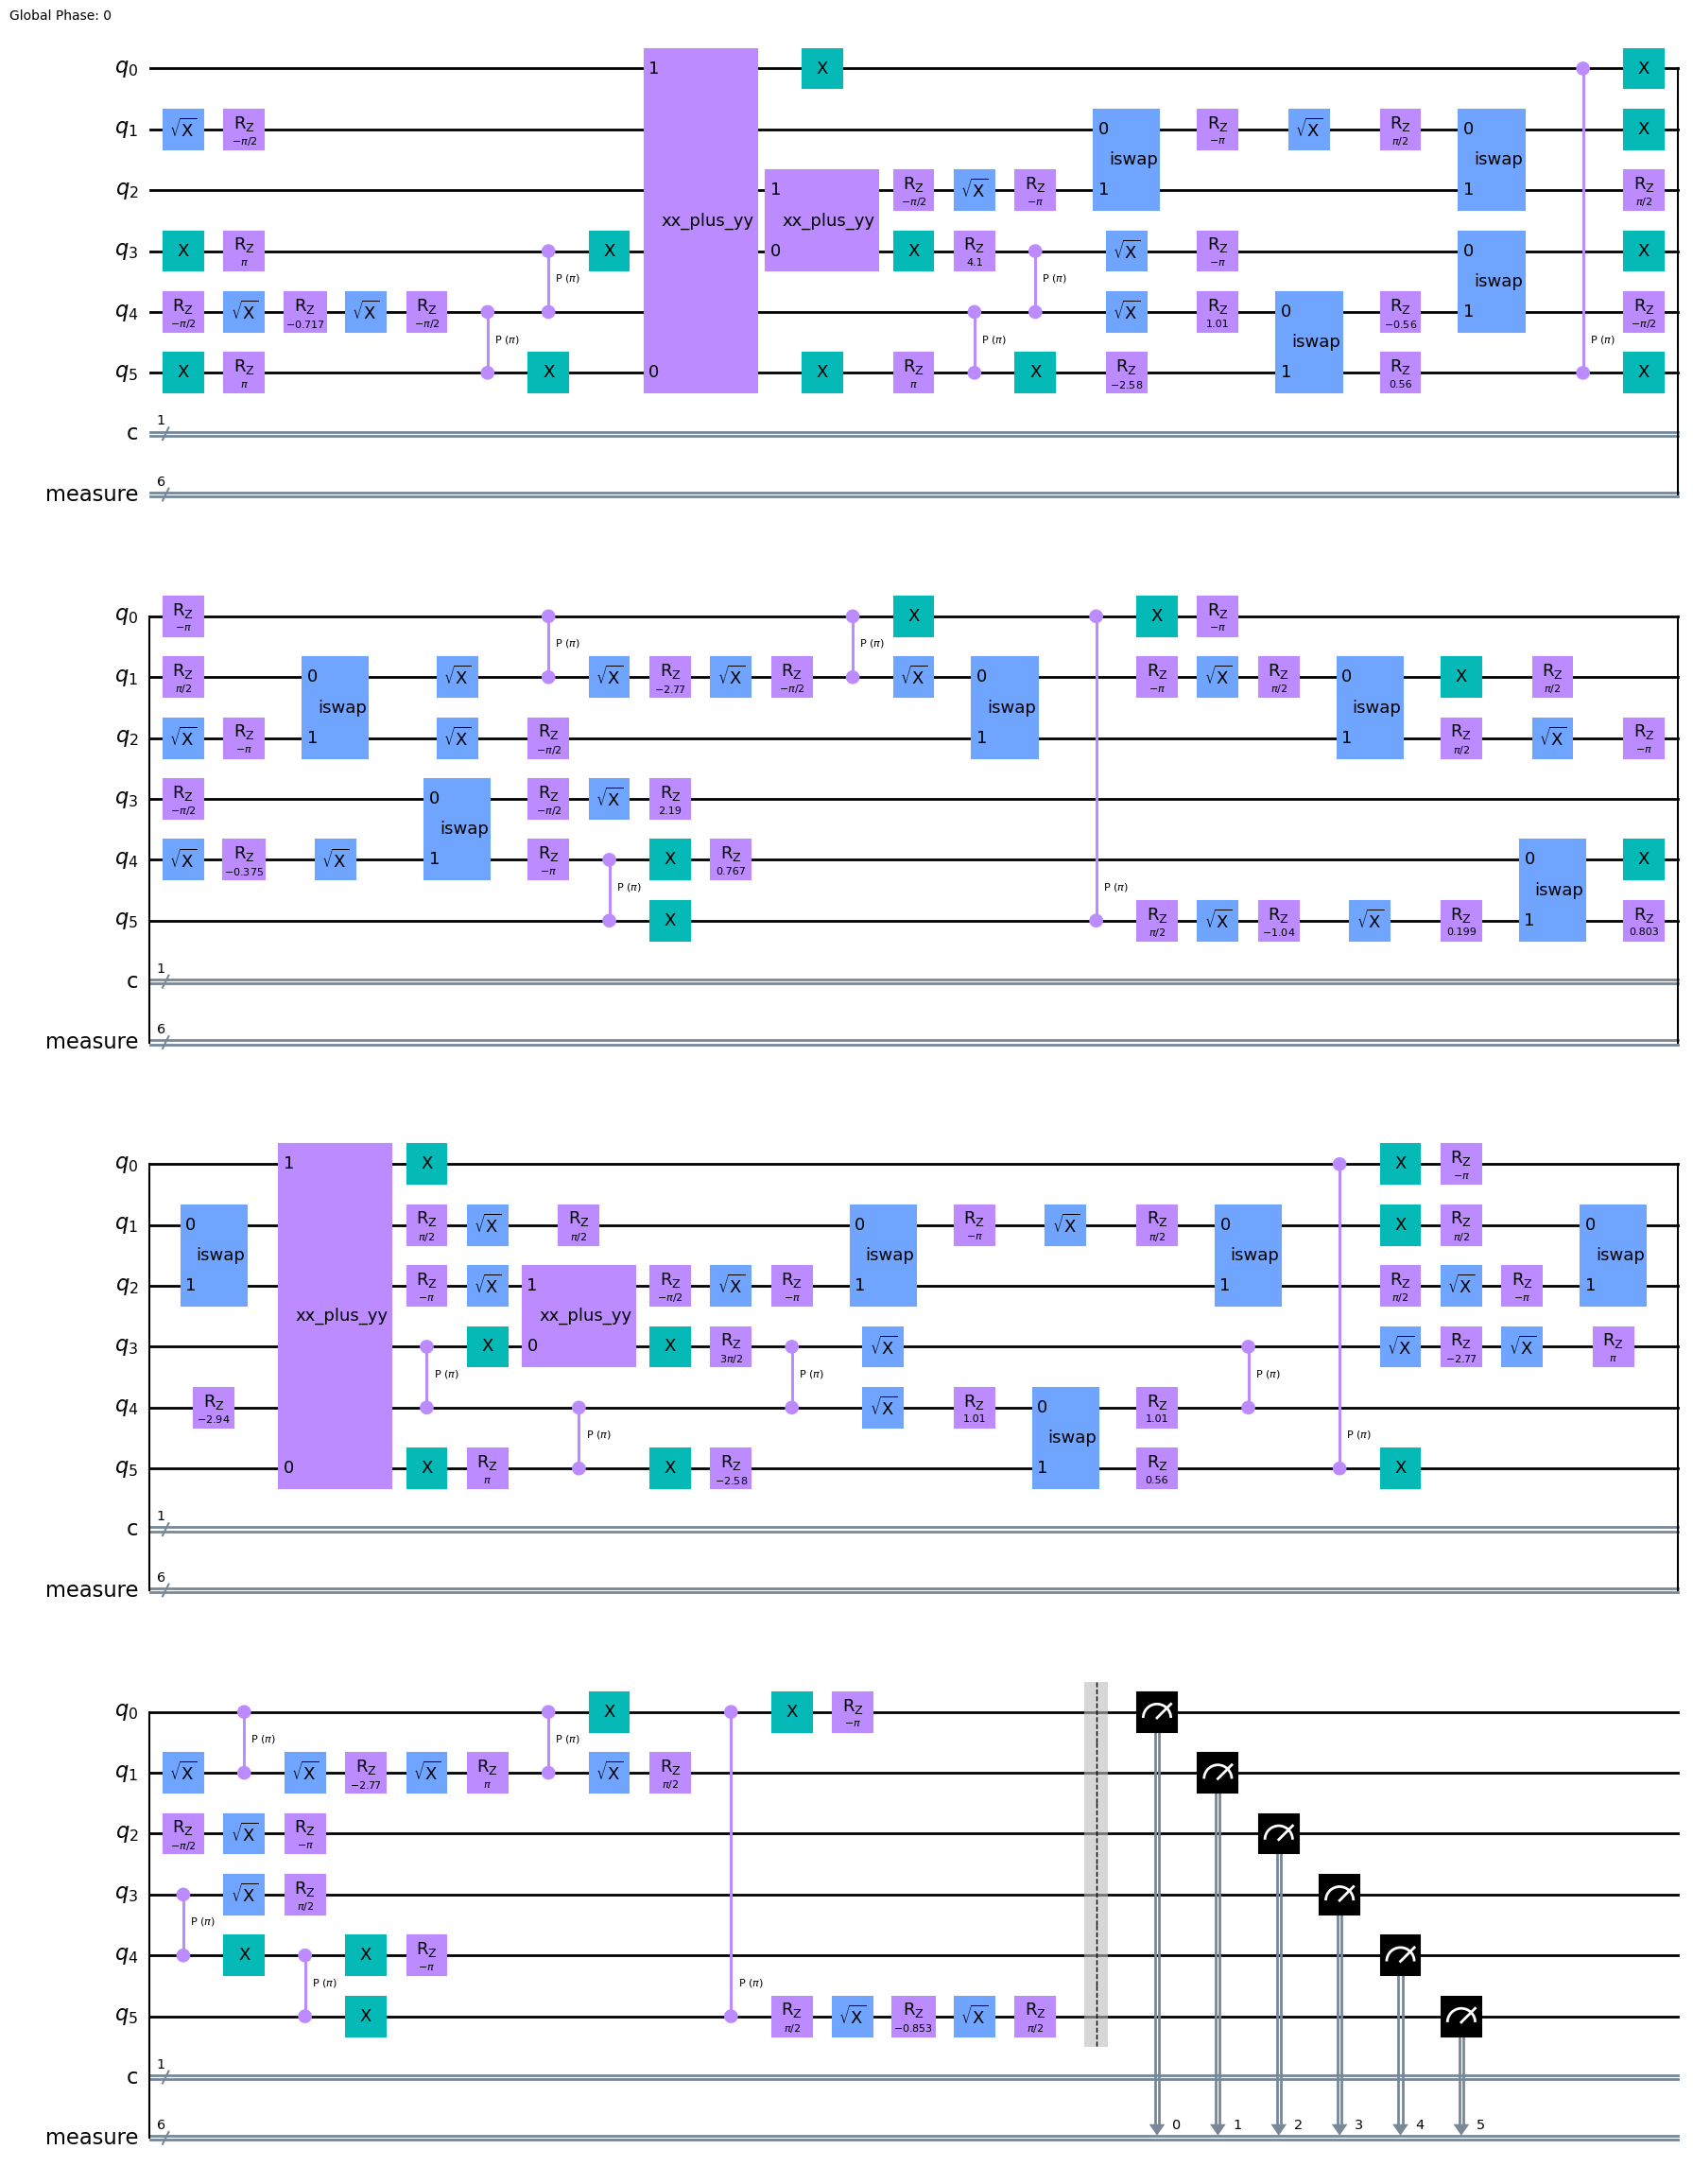

In [15]:
t_test_circ_noise.draw("mpl")

In [16]:
print(t_test_circ_noise.depth())

68


In [17]:
print(t_test_circ_noise.qasm())

OPENQASM 2.0;
include "qelib1.inc";
gate unitary q0,q1 { u(pi/2,-pi/2,pi/4) q0; u(1.6383671088811183,-pi/2,pi/4) q1; cx q0,q1; u(1.7168146928204135,0,-pi/2) q0; u(1.6283918050084518,-1.6377581577259697,2.9913847300775878) q1; cx q0,q1; u(pi/2,3*pi/4,-pi) q0; u(0.06757078208622144,-pi/4,-pi/2) q1; }
gate unitary_2692935353872 q0,q1 { u(pi/2,-pi/2,pi/2) q0; u(1.503225544708675,pi/2,-pi) q1; cx q0,q1; u(pi/2,0,-pi/2) q0; u(1.6382126755643593,-1.6385211889720481,3.137023392148679) q1; cx q0,q1; u(pi/2,-pi,0) q0; u(0.06757078208622143,pi/2,-pi/2) q1; }
gate unitary_2692938991440 q0,q1 { u(pi/2,-pi/2,pi/2) q0; u(1.503225544708675,pi/2,-pi) q1; cx q0,q1; u(pi/2,0,-pi/2) q0; u(1.6382126755643593,-1.6385211889720481,3.137023392148679) q1; cx q0,q1; u(pi/2,-pi,0) q0; u(0.06757078208622143,pi/2,-pi/2) q1; }
gate unitary_2692936939472 q0,q1 { u(pi/2,-pi/2,pi/2) q0; u(1.503225544708675,pi/2,-pi) q1; cx q0,q1; u(pi/2,0,-pi/2) q0; u(1.6382126755643593,-1.6385211889720481,3.137023392148679) q1; cx q0,